## makemore -- bigrams

following andrej karpathy's course (https://www.youtube.com/watch?v=PaCmpygFfXo)

his github: https://github.com/karpathy/makemore

we create two very different bigram models -- one by using the we counted up all the frequencies in the bigrams and normalized, and one by using a neural network (this one is way more flexible).

In [2]:
!curl -O https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt
!pip install torch

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  222k  100  222k    0     0   920k      0 --:--:-- --:--:-- --:--:--  920k

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

### bigram

essentially count how often each (c1, c2) pair appears in the dataset

In [4]:
word = words[0]

for c1, c2 in zip(word, word[1:]):
    print(c1, c2)

e m
m m
m a


In [5]:
from collections import Counter

b = Counter()
for word in words:
    word = ['<S>'] + list(word) + ['<E>']
    for c1, c2 in zip(word, word[1:]):
        bigram = (c1, c2)
        b[bigram] += 1

# getting most likely combinations
b.most_common()

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

now we store it more effectively in a tensor. also, instead of 2 special characters, we use 1 special character ('.')

In [6]:
import string

stoi = {c: i + 1 for i, c in enumerate(string.ascii_lowercase)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}

In [7]:
import torch

N = torch.zeros((27, 27), dtype=torch.int32)

for word in words:
    word = ['.'] + list(word) + ['.']
    for c1, c2 in zip(word, word[1:]):
        N[stoi[c1], stoi[c2]] += 1

N

tensor([[   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
         1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
          134,  535,  929],
        [6640,  556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568,
         2528, 1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,
          182, 2050,  435],
        [ 114,  321,   38,    1,   65,  655,    0,    0,   41,  217,    1,    0,
          103,    0,    4,  105,    0,    0,  842,    8,    2,   45,    0,    0,
            0,   83,    0],
        [  97,  815,    0,   42,    1,  551,    0,    2,  664,  271,    3,  316,
          116,    0,    0,  380,    1,   11,   76,    5,   35,   35,    0,    0,
            3,  104,    4],
        [ 516, 1303,    1,    3,  149, 1283,    5,   25,  118,  674,    9,    3,
           60,   30,   31,  378,    0,    1,  424,   29,    4,   92,   17,   23,
            0,  317,    1],
        [3983,  679,  121,  153,  384, 1271,   82,

visualizing the structure

(-0.5, 26.5, 26.5, -0.5)

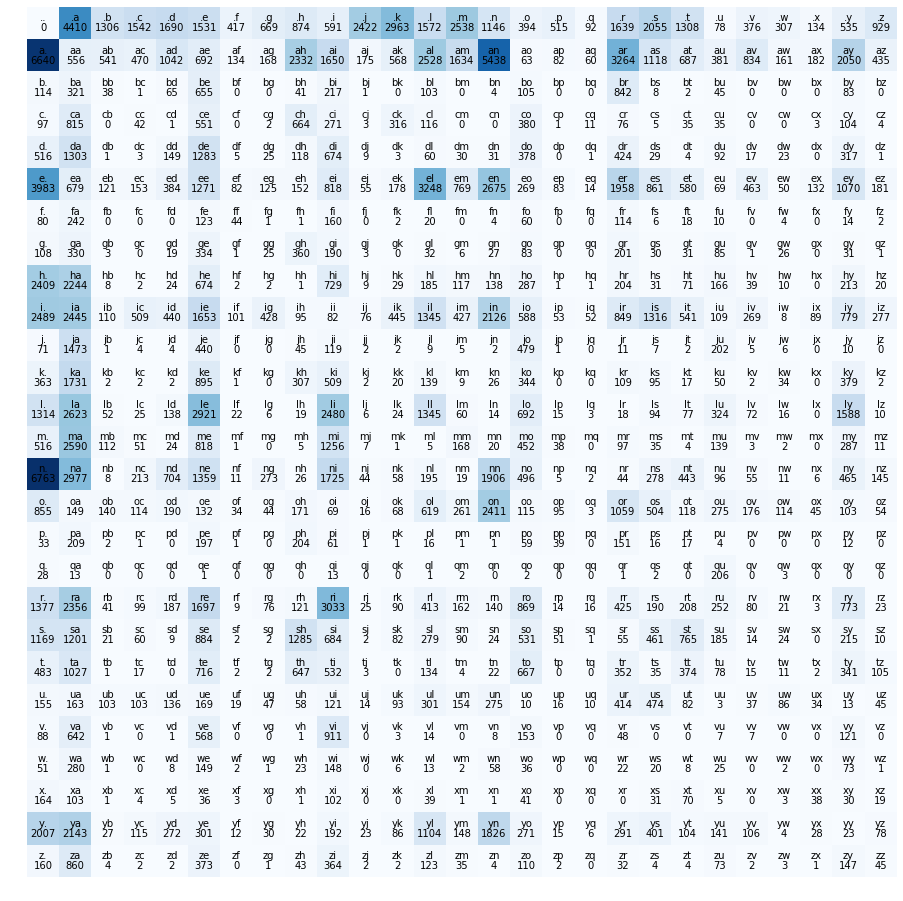

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')

for i in range(27):
    for j in range(27):
        chrstr = itos[i] + itos[j]
        plt.text(j, i, chrstr, ha='center', va='bottom', color='black')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='black')
plt.axis('off')

normalize, make it a probability distribution. then use torch.multinomial to sample from it. using a generator for deterministic results.

In [9]:
row = N[0].float()
row /= row.sum()

g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(row, num_samples=1, replacement=True, generator=g)
itos[ix.item()]

'm'

start from a random character, sample the index of the next character, repeat until we hit the end character.

In [10]:
P = N.float()
P /= P.sum(dim=1, keepdim=True)
P
ix = 0

In [11]:
print(P[0])
print(P[0].sum())

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])
tensor(1.)


In [12]:
for i in range(5):
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        print(itos[ix], end='')
        if ix == 0:
            break
    print()

so.
axx.
minaymoryles.
kondlaisah.
anchshizarie.


now we need a way of evaluating the performance of the model. we use log likelihood, which is a monotonic (never decreases) function.

we use negative log likelihood because the loss function is designed to like low values. with positive log likelihood the best case is 0 with the worst case being something super negative. so we invert.

In [13]:
import torch

N = torch.zeros((27, 27), dtype=torch.int32)
n = 0 # to normalize
ll = 0
for word in words[:3]:
    word = ['.'] + list(word) + ['.']
    for c1, c2 in zip(word, word[1:]):
        first, second = stoi[c1], stoi[c2]
        n += 1
        p = P[first, second]
        logprob = torch.log(p)
        print(f"{c2}{c1}: prob={p:.4f}, logprob={logprob:.4f}")
        ll += logprob
nll = -ll
print(nll/n)

e.: prob=0.0478, logprob=-3.0408
me: prob=0.0377, logprob=-3.2793
mm: prob=0.0253, logprob=-3.6772
am: prob=0.3899, logprob=-0.9418
.a: prob=0.1960, logprob=-1.6299
o.: prob=0.0123, logprob=-4.3982
lo: prob=0.0780, logprob=-2.5508
il: prob=0.1777, logprob=-1.7278
vi: prob=0.0152, logprob=-4.1867
iv: prob=0.3541, logprob=-1.0383
ai: prob=0.1381, logprob=-1.9796
.a: prob=0.1960, logprob=-1.6299
a.: prob=0.1377, logprob=-1.9829
va: prob=0.0246, logprob=-3.7045
av: prob=0.2495, logprob=-1.3882
.a: prob=0.1960, logprob=-1.6299
tensor(2.4241)


so 2.42 is a value for the quality of the model. if we try an outlandish name like "arnavc" we get a log likelihood of infinity. undesireable because we do not want the model to be so extreme, so we **smooth** the model by adding fake weights. we add 1 to all counts.

In [14]:
P = (N+1).float()
P /= P.sum(dim=1, keepdim=True)
P

tensor([[0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
         0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
         0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370],
        [0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
         0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
         0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370],
        [0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
         0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
         0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370],
        [0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
         0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
         0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370],
        [0.0370, 0.0370,

bottom cell just tests the example from the video.

In [15]:
import torch

N = torch.zeros((27, 27), dtype=torch.int32)
n = 0 # to normalize
ll = 0
for word in ["andrejq"]:
    word = ['.'] + list(word) + ['.']
    for c1, c2 in zip(word, word[1:]):
        first, second = stoi[c1], stoi[c2]
        n += 1
        p = P[first, second]
        logprob = torch.log(p)
        print(f"{c2}{c1}: prob={p:.4f}, logprob={logprob:.4f}")
        ll += logprob
nll = -ll
print(nll/n)

a.: prob=0.0370, logprob=-3.2958
na: prob=0.0370, logprob=-3.2958
dn: prob=0.0370, logprob=-3.2958
rd: prob=0.0370, logprob=-3.2958
er: prob=0.0370, logprob=-3.2958
je: prob=0.0370, logprob=-3.2958
qj: prob=0.0370, logprob=-3.2958
.q: prob=0.0370, logprob=-3.2958
tensor(3.2958)


create training set

In [16]:
xs, ys = [], []

for w in words[:1]:
    word = ['.'] + list(w) + ['.']
    for c1, c2 in zip(word, word[1:]):
        xs.append(stoi[c1])
        ys.append(stoi[c2])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

we one-hot encode the input

In [17]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=27).float()
xenc.shape

torch.Size([5, 27])

select initial weights from normal distribution

In [18]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g).float()
W

tensor([[ 1.5674e+00, -2.3729e-01, -2.7385e-02, -1.1008e+00,  2.8588e-01,
         -2.9644e-02, -1.5471e+00,  6.0489e-01,  7.9136e-02,  9.0462e-01,
         -4.7125e-01,  7.8682e-01, -3.2844e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4040e-01,
          9.8488e-01, -1.4837e-01, -1.4795e+00,  4.4830e-01, -7.0731e-02,
          2.4968e+00,  2.4448e+00],
        [-6.7006e-01, -1.2199e+00,  3.0314e-01, -1.0725e+00,  7.2762e-01,
          5.1114e-02,  1.3095e+00, -8.0220e-01, -8.5042e-01, -1.8068e+00,
          1.2523e+00, -1.2256e+00,  1.2165e+00, -9.6478e-01, -2.3211e-01,
         -3.4762e-01,  3.3244e-01, -1.3263e+00,  1.1224e+00,  5.9641e-01,
          4.5846e-01,  5.4011e-02, -1.7400e+00,  1.1560e-01,  8.0319e-01,
          5.4108e-01, -1.1646e+00],
        [ 1.4756e-01, -1.0006e+00,  3.8012e-01,  4.7328e-01, -9.1027e-01,
         -7.8305e-01,  1.3506e-01, -2.1161e-01, -1.0406e+00, -1.5367e+00,
          9.3743e-01, -8.8303e-01,  1.74

result below tells us what the *firing rate* of each neuron on each one of the 5 inputs

eg. (xenc @ W)[3, 13] tells us what the firing rate of the 13th neuron on 3rd input

= (xenc[3] * W[:, 13]).sum()

In [19]:
xenc @ W

tensor([[ 1.5674e+00, -2.3729e-01, -2.7385e-02, -1.1008e+00,  2.8588e-01,
         -2.9644e-02, -1.5471e+00,  6.0489e-01,  7.9136e-02,  9.0462e-01,
         -4.7125e-01,  7.8682e-01, -3.2844e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4040e-01,
          9.8488e-01, -1.4837e-01, -1.4795e+00,  4.4830e-01, -7.0731e-02,
          2.4968e+00,  2.4448e+00],
        [ 4.7236e-01,  1.4830e+00,  3.1748e-01,  1.0588e+00,  2.3982e+00,
          4.6827e-01, -6.5650e-01,  6.1662e-01, -6.2198e-01,  5.1007e-01,
          1.3563e+00,  2.3445e-01, -4.5585e-01, -1.3132e-03, -5.1161e-01,
          5.5570e-01,  4.7458e-01, -1.3867e+00,  1.6229e+00,  1.7197e-01,
          9.8846e-01,  5.0657e-01,  1.0198e+00, -1.9062e+00, -4.2753e-01,
         -2.1259e+00,  9.6041e-01],
        [ 1.9359e-01,  1.0532e+00,  6.3393e-01,  2.5786e-01,  9.6408e-01,
         -2.4855e-01,  2.4756e-02, -3.0404e-02,  1.5622e+00, -4.4852e-01,
         -1.2345e+00,  1.1220e+00, -6.73

neural network outputs logits (log counts), and then we exponentiate them to get probabilities. we can then interpret as "equivalents" to the counts in the heatmap

logits dont have much to do with counts, just think of them as raw numbers the model outputs that reflects its preferences, but they can be very extreme and hard to use with gradients

In [20]:
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
probs

tensor([[0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
         0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
         0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
        [0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
         0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
         0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0150, 0.0086,

summary, prepping training

In [21]:
nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram
    x = xs[i].item()
    y = ys[i].item()
    print('-'*10)
    print(f"bigram {i}: {itos[x]}{itos[y]} (indexes {x} {y})")
    print(f"input to nn: {x}")
    print(f"output of nn: {probs[i]}")
    print(f"label: {y}")
    p = probs[i, y]
    print(f"probability assigned by nn to the CORRECT character: {p.item():.4f}")
    logp = torch.log(p)
    print(f"log probability: {logp.item():.4f}")
    nll = -logp
    print(f"nll: {nll.item():.4f}")
    nlls[i] = nll

print(f"="*10)
print(f"average nll: {nlls.mean().item():.4f}")
    

----------
bigram 0: .e (indexes 0 5)
input to nn: 0
output of nn: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label: 5
probability assigned by nn to the CORRECT character: 0.0123
log probability: -4.3993
nll: 4.3993
----------
bigram 1: em (indexes 5 13)
input to nn: 5
output of nn: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label: 13
probability assigned by nn to the CORRECT character: 0.0181
log probability: -4.0146
nll: 4.0146
----------
bigram 2: mm (indexes 13 13)
input to nn: 13
output of nn: tensor([0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
        0.0164, 0.00

### optimization begins

In [53]:
# constructing training set
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        x = stoi[ch1]
        y = stoi[ch2]
        xs.append(x)
        ys.append(y)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [55]:
# doing 10 iterations of training
for k in range(100):
    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(num), ys].log().mean()

    # backward pass
    W.grad = None
    loss.backward()

    # update
    W.data += -1 * W.grad

print(f"loss: {loss.item():.4f}")
    

loss: 2.4722


Note -- w.exp() is the same as the heatmap array we had above.

the equivalent of smoothing in this model would be try to push each entry in W to be closer to 0, and make the probabilities more uniform. We can achieve this by regularization, which pushes the loss function in a specific direction (or 0)

now we sample from our new model

In [51]:
r = W[0]
sum(r)

tensor(8.8087, grad_fn=<AddBackward0>)

In [58]:
for i in range(5):
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum()
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        print(itos[ix], end='')
        if ix == 0:
            break
    print()

ja.
amyda.
jeyndkanakyn.
jon.
ntoushana.
